# 프로젝트: 자율주행 보조 시스템 만들기

## 1. 자율주행 시스템 만들기

### 다음 조건을 만족하는 함수를 만든다.
### * input으로 이미지 경로를 받는다.
### * 조건에 따라 "Stop"과 "Go"를 return
### * 그 조건은 다음과 같다.
#### 1) 사람이 있는 경우
#### 2) 차량의 크기가 300px이상인 경우

In [14]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras



# Helper libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import os

import tensorflow_datasets as tfds

import copy
import cv2
from PIL import Image, ImageDraw

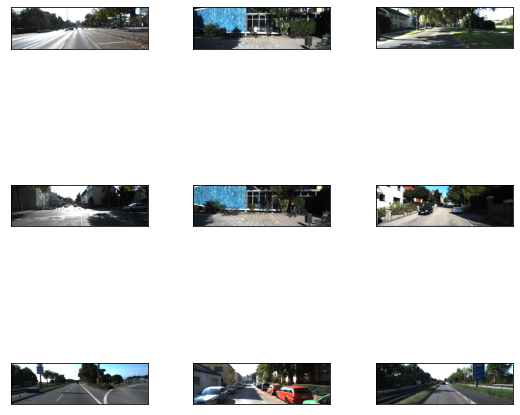

In [16]:
import urllib3
urllib3.disable_warnings()

data_dir = os.path.join(os.getenv("HOME"), "aiffel/object_detection/data")

(ds_train, ds_test), ds_info = tfds.load(
    'kitti',
    data_dir=data_dir,
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)

_ = tfds.show_examples(ds_train, ds_info)

In [17]:
ds_info

tfds.core.DatasetInfo(
    name='kitti',
    full_name='kitti/3.2.0',
    description="""
    Kitti contains a suite of vision tasks built using an autonomous driving
    platform. The full benchmark contains many tasks such as stereo, optical flow,
    visual odometry, etc. This dataset contains the object detection dataset,
    including the monocular images and bounding boxes. The dataset contains 7481
    training images annotated with 3D bounding boxes. A full description of the
    annotations can be found in the readme of the object development kit readme on
    the Kitti homepage.
    """,
    homepage='http://www.cvlibs.net/datasets/kitti/',
    data_path='/aiffel/aiffel/object_detection/data/kitti/3.2.0',
    download_size=11.71 GiB,
    dataset_size=5.27 GiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'image/file_name': Text(shape=(), dtype=tf.string),
        'objects': Sequence({
            'alpha': tf.float32,
     

### 데이터 확인

------Example------
['image', 'image/file_name', 'objects']
------objects------
{'alpha': <tf.Tensor: shape=(5,), dtype=float32, numpy=array([ 1.73,  2.65, -1.56,  2.05, -1.94], dtype=float32)>, 'bbox': <tf.Tensor: shape=(5, 4), dtype=float32, numpy=
array([[0.3632    , 0.3308132 , 0.65037334, 0.41966185],
       [0.42693335, 0.72769725, 0.49744   , 0.786095  ],
       [0.37869334, 0.4491546 , 0.5291733 , 0.49472624],
       [0.45568   , 0.192343  , 0.5199467 , 0.23527375],
       [0.41853333, 0.67201287, 0.51794666, 0.6890741 ]], dtype=float32)>, 'dimensions': <tf.Tensor: shape=(5, 3), dtype=float32, numpy=
array([[2.84, 2.22, 6.86],
       [1.68, 1.39, 4.26],
       [1.62, 1.63, 4.5 ],
       [1.46, 1.31, 4.15],
       [1.64, 0.34, 1.58]], dtype=float32)>, 'location': <tf.Tensor: shape=(5, 3), dtype=float32, numpy=
array([[ -4.28,   1.78,  22.62],
       [ 22.13,   2.76,  48.48],
       [ -0.78,   1.76,  23.22],
       [-22.  ,   1.93,  46.19],
       [ 10.62,   2.01,  32.69]], dtype

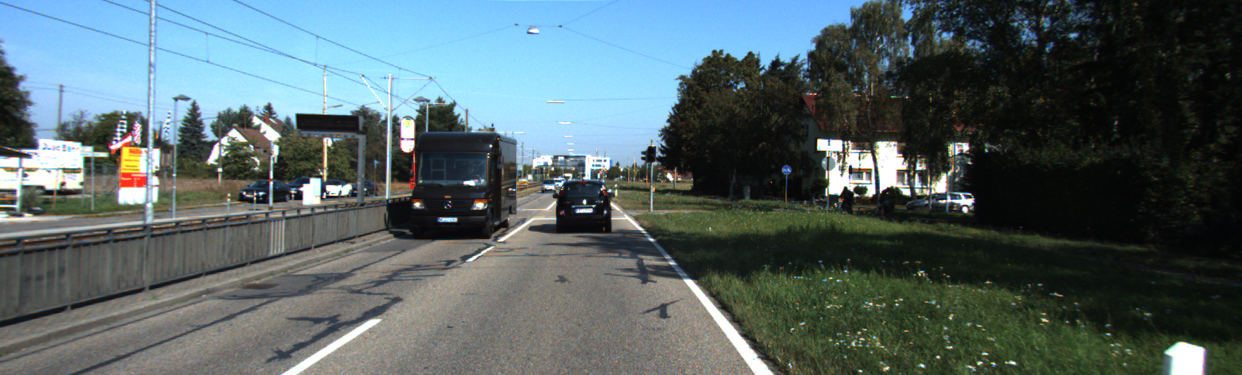

In [18]:
sample = ds_train.take(1) #.take(1) 데이터를 하나씩 뽑는다.

for example in sample:  
    print('------Example------')
    print(list(example.keys())) # example is `{'image': tf.Tensor, 'label': tf.Tensor}`
    image = example["image"]
    filename = example["image/file_name"].numpy().decode('utf-8')
    objects = example["objects"]
    
print('------objects------')
print(objects)

img = Image.fromarray(image.numpy())
img

width: 1242 height: 375
(5, 4)
[410.87    238.8     521.22003 131.11   ]
[903.8     214.9     976.33    188.45999]
[557.85    232.98999 614.45    176.56001]
[238.89    204.12    292.21    180.01999]
[834.63995 218.05    855.83    180.77   ]
<PIL.Image.Image image mode=RGB size=1242x375 at 0x7FC07C6F8050>


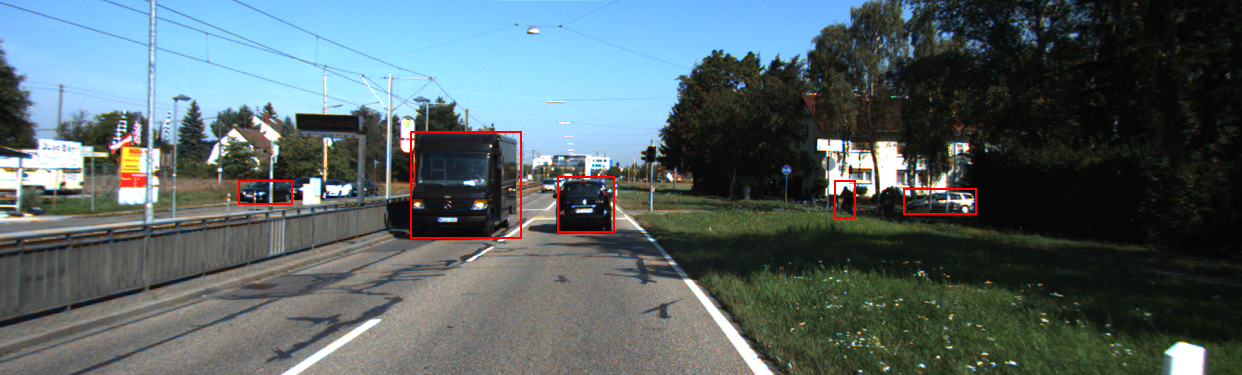

In [19]:
def visualize_bbox(input_image, object_bbox):
    input_image  = copy.deepcopy(input_image)
    draw = ImageDraw.Draw(input_image)
    
    #바운딩 박스 좌표(x_min, x_max, y_min, y_max)구하기
    width,height=img.size
    print('width:',width, 'height:',height)
    print(object_bbox.shape)
#     print(object_bbox)
    x_min = object_bbox[:,1] * width
    x_max = object_bbox[:,3] * width
    y_min = height - object_bbox[:,0] * height
    y_max = height - object_bbox[:,2] * height
    
    # 바운당 박스 그리기
    rects = np.stack([x_min, y_min, x_max, y_max], axis = 1)
    for _rect in rects:
        print(_rect)
        draw.rectangle(_rect, outline=(255,0,0), width=2)
    print(input_image)
    return input_image
    
visualize_bbox(img, objects['bbox'].numpy())

### RetinaNet 사용하기

In [20]:
import os
data_dir = os.getenv('HOME') + '/aiffel/object_detection/data'
img_dir = data_dir + '/kitti_images'
train_csv_path = data_dir + '/kitti_train.csv'

# KITTI 데이터셋 ds_train을 파싱해서 dataframe으로 변환하는 parse_dataset 함수를 구현해 주세요.
def parse_dataset(dataset, img_dir, total=0):
    if not os.path.exists(img_dir):
        os.mkdir(img_dir)
    # Dataset의 claas를 확인하여 class에 따른 index를 확인해둡니다.
    # 저는 기존의 class를 차와 사람으로 나누었습니다.
    type_class_map = {
        0: "car",
        1: "car",
        2: "car",
        3: "person",
        4: "person",
        5: "person",
    }
    # Keras retinanet을 학습하기 위한 dataset을 csv로 parsing하기 위해서 필요한 column을 가진 pandas.DataFrame을 생성합니다.
    df = pd.DataFrame(columns=["img_path", "x1", "y1", "x2", "y2", "class_name"])
    for item in tqdm(dataset, total=total):
        filename = item['image/file_name'].numpy().decode('utf-8')
        img_path = os.path.join(img_dir, filename)
        
        img = Image.fromarray(item['image'].numpy())
        img.save(img_path)
        object_bbox = item['objects']['bbox']
        object_type = item['objects']['type'].numpy()
        width, height = img.size
        
        # tf.dataset의 bbox좌표가 0과 1사이로 normalize된 좌표이므로 이를 pixel좌표로 변환합니다.
        x_min = object_bbox[:,1] * width
        x_max = object_bbox[:,3] * width
        y_min = height - object_bbox[:,2] * height
        y_max = height - object_bbox[:,0] * height
        
        # 한 이미지에 있는 여러 Object들을 한 줄씩 pandas.DataFrame에 append합니다.
        rects = np.stack([x_min, y_min, x_max, y_max], axis=1).astype(np.int)
        for i, _rect in enumerate(rects):
            _type = object_type[i]
            if _type not in type_class_map.keys():
                continue
            df = df.append({
                "img_path": img_path,
                "x1": _rect[0],
                "y1": _rect[1],
                "x2": _rect[2],
                "y2": _rect[3],
                "class_name": type_class_map[_type]
            }, ignore_index=True)
    return df

df_train = parse_dataset(ds_train, img_dir, total=ds_info.splits['train'].num_examples)
df_train.to_csv(train_csv_path, sep=',', index=False, header=False)
    

100%|██████████| 6347/6347 [22:27<00:00,  4.71it/s]


In [21]:
# 데이터프레임 생성하기
test_csv_path = data_dir + '/kitti_test.csv'

df_test = parse_dataset(ds_test, img_dir, total=ds_info.splits['test'].num_examples)
df_test.to_csv(test_csv_path, sep=',', index=False, header=False)

100%|██████████| 711/711 [02:36<00:00,  4.54it/s]


In [22]:
# 클래스 매핑
class_txt_path = data_dir + '/classes.txt'

def save_class_format(path):
    # 클래스 딕셔너리 만들기
    class_type = {"car":0, "person":1}
    
    # 파일불러와서 키, 밸류로 출려가하기
    with open(path, mode='w', encoding='utf-8')as f:
        for k,v in class_type.items():
            f.write(f"{k},{v}\n")
    print("완료")


save_class_format(class_txt_path)

완료


### Keras-retinanet setting

In [23]:
!cd ~/aiffel/object_detection && python keras-retinanet/keras_retinanet/bin/train.py --gpu 0 --multiprocessing --workers 4 --batch-size 2 --epochs 10 --steps 195 csv data/kitti_train.csv data/classes.txt
print("완료")

2021-10-19 07:29:48.211534: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
Traceback (most recent call last):
  File "keras-retinanet/keras_retinanet/bin/train.py", line 38, in <module>
    from ..callbacks.eval import Evaluate
  File "keras-retinanet/keras_retinanet/bin/../../keras_retinanet/callbacks/eval.py", line 18, in <module>
    from ..utils.eval import evaluate
  File "keras-retinanet/keras_retinanet/bin/../../keras_retinanet/utils/eval.py", line 26, in <module>
    import progressbar
ModuleNotFoundError: No module named 'progressbar'
완료


In [24]:
# 케라스 모델로 변환
!cd ~/aiffel/object_detection && python keras-retinanet/keras_retinanet/bin/convert_model.py snapshots/resnet50_csv_10.h5 snapshots/resnet50_csv_10_infer.h5
print("완료")

2021-10-19 07:29:51.163786: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2021-10-19 07:29:52.797341: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-10-19 07:29:52.798277: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-10-19 07:29:52.806387: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0001:00:00.0 name: Tesla K80 computeCapability: 3.7
coreClock: 0.8235GHz coreCount: 13 deviceMemorySize: 11.17GiB deviceMemoryBandwidth: 223.96GiB/s
2021-10-19 07:29:52.806427: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2021-10-19 07:29:52.809796: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2021-10-19

In [12]:
img_path = os.getenv('HOME')+'/aiffel/object_detection/test_set/go_1.png'

def self_drive_assist(img_path, size_limit=300):
    # 코드 구현
    image = read_image(img_path)
    width, height=image.size
    print('width:',width,'heigth:',height)
    
		# 정지조건에 맞으면 return "Stop"
    if (size_limit >= width or height):
        return "Stop"
    else :
        return "Go"
		# 아닌 경우 return "Go"

print(self_drive_assist(img_path))

NameError: name 'read_image' is not defined